# Predict The News Category Hackathon

Link : <code>https://machinehack.com/hackathons/predict_the_news_category_hackathon/overview</code>

<p>From the beginning, since the first printed newspaper, every news that makes into a page has had a specific section allotted to it. Although pretty much everything changed in newspapers from the ink to the type of paper used, this proper categorization of news was carried over by generations and even to the digital versions of the newspaper. Newspaper articles are not limited to a few topics or subjects, it covers a wide range of interests from politics to sports to movies and so on. For long, this process of sectioning was done manually by people but now technology can do it without much effort. In this hackathon, Data Science and Machine Learning enthusiasts like you will use Natural Language Processing to predict which genre or category a piece of news will fall in to from the story.</p>
    
<p>Size of training set: 7,628 records Size of test set: 2,748 records 

<b>Features:</b><br>
<i>STORY:</i>  A part of the main content of the article to be published as a piece of news.<br>
<i>SECTION:</i> The genre/category the STORY falls in. 
    
There are four distinct sections where each story may fall in to:
- Politics: 0 
- Technology: 1 
- Entertainment: 2 
- Business: 3

<b>Evaluation:</b><br>
<code>accuracy_score metric</code>

### Environment Setup

In [23]:
# Importing the data manipulation libraries
import pandas as pd
import numpy as np

# Importing the data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing NLP libraries
import nltk
import string
from nltk.tokenize import word_tokenize
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('punkt')

nlp = en_core_web_sm.load()

# Importing important pre-experimentation libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, roc_curve

# Importing Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\neela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Dataset

In [4]:
# Importing the dataset
train_df = pd.read_excel("data/Data_Train.xlsx")
test_df = pd.read_excel("data/Data_Test.xlsx")

In [5]:
print("Training Dataset Shape : " + str(train_df.shape))
print("Test Dataset Shape : " + str(test_df.shape))

Training Dataset Shape : (7628, 2)
Test Dataset Shape : (2748, 1)


### Exploratory Data Analysis

In [6]:
train_df.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [7]:
train_df.dtypes

STORY      object
SECTION     int64
dtype: object

<Axes: title={'center': 'Class Distribution'}>

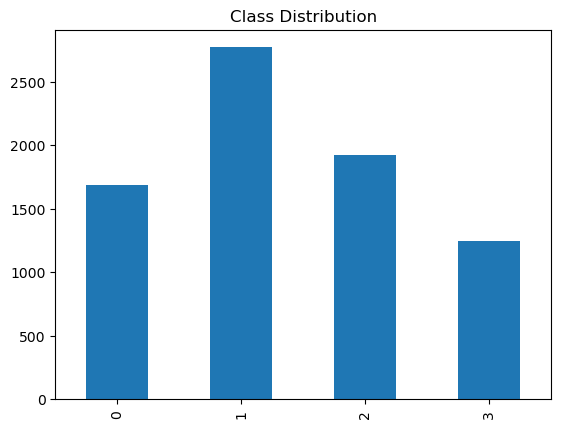

In [8]:
# Visualizing the class distribution of the training dataset

train_df['SECTION'].value_counts().sort_index().plot(kind='bar', title="Class Distribution")

Text(0.5, 1.0, 'Business Stories')

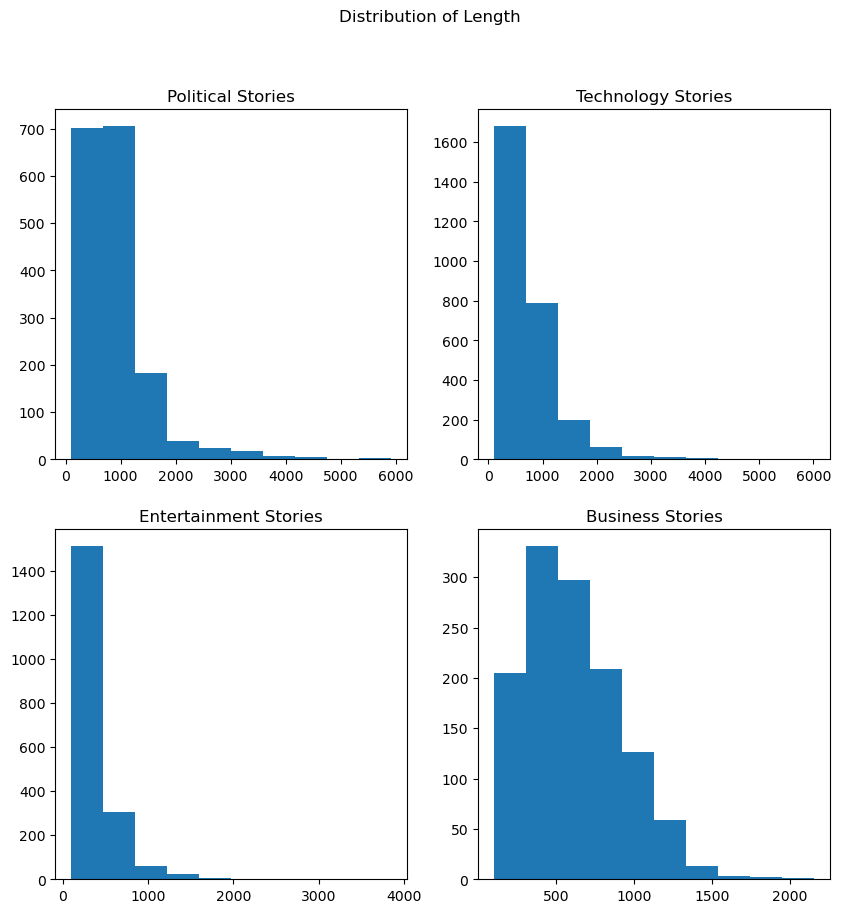

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(10, 10))


train_df_0 = train_df[train_df['SECTION'] == 0]['STORY'].str.len()
train_df_1 = train_df[train_df['SECTION'] == 1]['STORY'].str.len()
train_df_2 = train_df[train_df['SECTION'] == 2]['STORY'].str.len()
train_df_3 = train_df[train_df['SECTION'] == 3]['STORY'].str.len()

fig.suptitle("Distribution of Length")

ax1[0].hist(train_df_0)
ax1[0].set_title("Political Stories")
ax1[1].hist(train_df_1)
ax1[1].set_title("Technology Stories")
ax2[0].hist(train_df_2)
ax2[0].set_title("Entertainment Stories")
ax2[1].hist(train_df_3)
ax2[1].set_title("Business Stories")

### Text Pre-Processing

In [13]:
def remove_punctuations(data):
    '''
    This function removes punctuations from the text
    '''
    return [char for char in data if char.text not in string.punctuation]

def remove_stopwords(data):
    '''
    This function removes the stop-words from the text
    '''
    return [word for word in data if not word.is_stop]

def lemmatization(data):
    '''
    This function lemmatizes the text
    '''
    return ' '.join([word.lemma_ for word in data])

def text_preprocess(data):
    '''
    This functions is the text preprocessing pipeline
    
    1. Normalization
    2. Remove Punctuations
    3. Remove StopWords
    4. Lemmatization
    '''
    
    # 1. Normalization : Converting all the text to it's lowercase
    data = data.lower()
    
    # Converting the text into NLP format
    data = nlp(data)
    
    # 2. Removing punctuations
    data = remove_punctuations(data)
    
    # 3. Removing the stopwords
    data = remove_stopwords(data)
    
    # 4. Lemmatization
    data = lemmatization(data)
    
    return data

In [20]:
train_df['STORY'] = train_df['STORY'].apply(text_preprocess)
test_df['STORY'] = test_df['STORY'].apply(text_preprocess)

### Machine Learning Model Experimentation

In [57]:
# Creating a dictionary of Machine Learning Models
model = {'MultinomialNaiveBayes'  : MultinomialNB(),
         'K-NearestNeighbors'     : KNeighborsClassifier(n_jobs=-1),
         'SupportVectorMachines'  : SVC(),
         'DecisionTrees'          : DecisionTreeClassifier(),
         'LogisticRegression'     : LogisticRegression(n_jobs=-1),
         'RandomForest'           : RandomForestClassifier(n_jobs=-1),
         'GradientBoosting'       : GradientBoostingClassifier(),
         'ADABoosting'            : AdaBoostClassifier(),
         'XGBoosting'             : XGBClassifier(n_jobs=-1)}

# Creating a model experimentation pipeline
def model_experimentation(X, y, models):
    model_score = {}
    for name, model in models.items():
        print("10-Fold Cross-Validation : ", name)
        
        model_score[name] = np.mean(cross_val_score(model, 
                                                    X,
                                                    y,
                                                    cv=10,
                                                    scoring='accuracy',
                                                    verbose=2,
                                                    n_jobs=-1))
        print("Finished Experimentation with ", name)
    # Converting model_score to DataFrame
    model_score = {'10-Fold CV Score': model_score}
    model_score_df = pd.DataFrame(model_score)
    model_score_df.rename_axis('Model', inplace=True)
    model_score_df.reset_index(inplace=True)
    model_score_df.sort_values('10-Fold CV Score', ascending=False, inplace=True)
    return model_score_df

#### Bag-of-Words (BoW)

In [33]:
labels = train_df['SECTION']
textData = train_df['STORY']

In [34]:
# Creating Bag-of-Words
bow_fit = CountVectorizer().fit(textData)
bow_transform = bow_fit.transform(textData)
print("Vocabulary Length : ", len(bow_fit.vocabulary_))

Vocabulary Length :  26643


In [35]:
bow_score = model_experimentation(bow_transform, labels, model)

10-Fold Cross-Validation :  Multinomial Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Finished Experimentation with  Multinomial Naive Bayes
10-Fold Cross-Validation :  K-Nearest Neighbors


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  K-Nearest Neighbors
10-Fold Cross-Validation :  Support Vector Machines


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.0s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished


Finished Experimentation with  Support Vector Machines
10-Fold Cross-Validation :  Decision Trees


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Finished Experimentation with  Decision Trees
10-Fold Cross-Validation :  Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.5s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Finished Experimentation with  Logistic Regression
10-Fold Cross-Validation :  Random Forest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.8s remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  Random Forest
10-Fold Cross-Validation :  Gradient Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


Finished Experimentation with  Gradient Boosting
10-Fold Cross-Validation :  ADA Boosting


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   10.0s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  ADA Boosting
10-Fold Cross-Validation :  XG Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   14.6s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  XG Boosting
10-Fold Cross-Validation :  Cat Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  5.9min remaining: 13.7min


Finished Experimentation with  Cat Boosting


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.9min finished


In [36]:
bow_score

,Model,10-Fold CV Score
6,Multinomial Naive Bayes,0.971159
5,Logistic Regression,0.964604
9,XG Boosting,0.953986
7,Random Forest,0.952938
8,Support Vector Machines,0.939303
1,Cat Boosting,0.933403
3,Gradient Boosting,0.931043
2,Decision Trees,0.890926
0,ADA Boosting,0.887915
4,K-Nearest Neighbors,0.712903


#### TF-IDF Model

In [38]:
tfidf_fit = TfidfVectorizer().fit(textData)
tfidf_transform = tfidf_fit.transform(textData)

In [39]:
tfidf_score = model_experimentation(tfidf_transform, labels, model)

10-Fold Cross-Validation :  Multinomial Naive Bayes
Finished Experimentation with  Multinomial Naive Bayes
10-Fold Cross-Validation :  K-Nearest Neighbors


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.4s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  K-Nearest Neighbors
10-Fold Cross-Validation :  Support Vector Machines


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   19.6s remaining:   45.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  Support Vector Machines
10-Fold Cross-Validation :  Decision Trees


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


Finished Experimentation with  Decision Trees
10-Fold Cross-Validation :  Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


Finished Experimentation with  Logistic Regression
10-Fold Cross-Validation :  Random Forest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.1s remaining:   28.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  Random Forest
10-Fold Cross-Validation :  Gradient Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.3min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  Gradient Boosting
10-Fold Cross-Validation :  ADA Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   11.5s remaining:   26.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  ADA Boosting
10-Fold Cross-Validation :  XG Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   35.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Finished Experimentation with  XG Boosting
10-Fold Cross-Validation :  Cat Boosting


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 26.5min remaining: 61.9min


Finished Experimentation with  Cat Boosting


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 26.8min finished
C:\Users\neela\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\neela\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\neela\anaconda3\lib\site-packages\catboost\core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Us

In [40]:
tfidf_score

,Model,10-Fold CV Score
8,Support Vector Machines,0.969978
5,Logistic Regression,0.966439
7,Random Forest,0.952151
9,XG Boosting,0.950446
4,K-Nearest Neighbors,0.948216
6,Multinomial Naive Bayes,0.946774
3,Gradient Boosting,0.932747
0,ADA Boosting,0.879524
2,Decision Trees,0.878342
1,Cat Boosting,NaN


#### Final Model Submission

In [44]:
# Preprocessing the test dataset
test_df['STORY'] = test_df['STORY'].apply(text_preprocess)

In [56]:
# Converting to BoW model
bow_transform_test = bow_fit.transform(test_df['STORY'])

for name, model in model.items():
    final_model = model
    final_model.fit(bow_transform, labels)
    pred = final_model.predict(bow_transform_test)
    submission = pd.DataFrame()
    submission['SECTION'] = pred
    submission.to_csv("data/submission/bow_"+name+".csv")

Learning rate set to 0.087766
0:	learn: 1.2760168	total: 227ms	remaining: 3m 46s
1:	learn: 1.1957301	total: 295ms	remaining: 2m 27s
2:	learn: 1.1326422	total: 363ms	remaining: 2m
3:	learn: 1.0790424	total: 432ms	remaining: 1m 47s
4:	learn: 1.0296890	total: 502ms	remaining: 1m 39s
5:	learn: 0.9902636	total: 575ms	remaining: 1m 35s
6:	learn: 0.9555733	total: 648ms	remaining: 1m 31s
7:	learn: 0.9211503	total: 715ms	remaining: 1m 28s
8:	learn: 0.8913597	total: 784ms	remaining: 1m 26s
9:	learn: 0.8647178	total: 852ms	remaining: 1m 24s
10:	learn: 0.8374689	total: 923ms	remaining: 1m 22s
11:	learn: 0.8149692	total: 994ms	remaining: 1m 21s
12:	learn: 0.7928340	total: 1.07s	remaining: 1m 21s
13:	learn: 0.7724389	total: 1.14s	remaining: 1m 20s
14:	learn: 0.7565275	total: 1.21s	remaining: 1m 19s
15:	learn: 0.7403066	total: 1.28s	remaining: 1m 18s
16:	learn: 0.7252391	total: 1.35s	remaining: 1m 17s
17:	learn: 0.7108081	total: 1.42s	remaining: 1m 17s
18:	learn: 0.6959647	total: 1.49s	remaining: 1m 

162:	learn: 0.2954160	total: 11.6s	remaining: 59.8s
163:	learn: 0.2945656	total: 11.7s	remaining: 59.7s
164:	learn: 0.2944534	total: 11.8s	remaining: 59.6s
165:	learn: 0.2943670	total: 11.8s	remaining: 59.5s
166:	learn: 0.2939719	total: 11.9s	remaining: 59.4s
167:	learn: 0.2938698	total: 12s	remaining: 59.3s
168:	learn: 0.2937385	total: 12.1s	remaining: 59.3s
169:	learn: 0.2930409	total: 12.1s	remaining: 59.2s
170:	learn: 0.2927318	total: 12.2s	remaining: 59.1s
171:	learn: 0.2925778	total: 12.3s	remaining: 59s
172:	learn: 0.2920160	total: 12.3s	remaining: 58.9s
173:	learn: 0.2910070	total: 12.4s	remaining: 58.8s
174:	learn: 0.2906230	total: 12.5s	remaining: 58.7s
175:	learn: 0.2896237	total: 12.5s	remaining: 58.7s
176:	learn: 0.2895500	total: 12.6s	remaining: 58.7s
177:	learn: 0.2889344	total: 12.7s	remaining: 58.6s
178:	learn: 0.2887881	total: 12.8s	remaining: 58.5s
179:	learn: 0.2886065	total: 12.8s	remaining: 58.4s
180:	learn: 0.2883824	total: 12.9s	remaining: 58.3s
181:	learn: 0.28

324:	learn: 0.2550579	total: 22.8s	remaining: 47.3s
325:	learn: 0.2548412	total: 22.8s	remaining: 47.2s
326:	learn: 0.2547404	total: 22.9s	remaining: 47.1s
327:	learn: 0.2546870	total: 23s	remaining: 47s
328:	learn: 0.2542385	total: 23s	remaining: 47s
329:	learn: 0.2541894	total: 23.1s	remaining: 46.9s
330:	learn: 0.2541435	total: 23.2s	remaining: 46.8s
331:	learn: 0.2539301	total: 23.2s	remaining: 46.8s
332:	learn: 0.2538185	total: 23.3s	remaining: 46.7s
333:	learn: 0.2537638	total: 23.4s	remaining: 46.6s
334:	learn: 0.2536498	total: 23.4s	remaining: 46.5s
335:	learn: 0.2535921	total: 23.5s	remaining: 46.5s
336:	learn: 0.2535288	total: 23.6s	remaining: 46.4s
337:	learn: 0.2534561	total: 23.7s	remaining: 46.3s
338:	learn: 0.2533979	total: 23.7s	remaining: 46.3s
339:	learn: 0.2533320	total: 23.8s	remaining: 46.2s
340:	learn: 0.2532791	total: 23.9s	remaining: 46.1s
341:	learn: 0.2531683	total: 23.9s	remaining: 46s
342:	learn: 0.2530245	total: 24s	remaining: 45.9s
343:	learn: 0.2529910	to

484:	learn: 0.2370219	total: 33.6s	remaining: 35.7s
485:	learn: 0.2366061	total: 33.6s	remaining: 35.6s
486:	learn: 0.2365505	total: 33.7s	remaining: 35.5s
487:	learn: 0.2365222	total: 33.8s	remaining: 35.4s
488:	learn: 0.2364224	total: 33.8s	remaining: 35.4s
489:	learn: 0.2362980	total: 33.9s	remaining: 35.3s
490:	learn: 0.2362503	total: 34s	remaining: 35.2s
491:	learn: 0.2362073	total: 34s	remaining: 35.1s
492:	learn: 0.2358769	total: 34.1s	remaining: 35.1s
493:	learn: 0.2358463	total: 34.2s	remaining: 35s
494:	learn: 0.2357744	total: 34.3s	remaining: 35s
495:	learn: 0.2357408	total: 34.3s	remaining: 34.9s
496:	learn: 0.2355919	total: 34.4s	remaining: 34.8s
497:	learn: 0.2355678	total: 34.5s	remaining: 34.8s
498:	learn: 0.2355061	total: 34.5s	remaining: 34.7s
499:	learn: 0.2354853	total: 34.6s	remaining: 34.6s
500:	learn: 0.2354572	total: 34.7s	remaining: 34.5s
501:	learn: 0.2354238	total: 34.7s	remaining: 34.5s
502:	learn: 0.2353796	total: 34.8s	remaining: 34.4s
503:	learn: 0.235325

646:	learn: 0.2209173	total: 44.5s	remaining: 24.3s
647:	learn: 0.2208789	total: 44.6s	remaining: 24.2s
648:	learn: 0.2208347	total: 44.7s	remaining: 24.2s
649:	learn: 0.2207954	total: 44.7s	remaining: 24.1s
650:	learn: 0.2207695	total: 44.8s	remaining: 24s
651:	learn: 0.2207473	total: 44.9s	remaining: 23.9s
652:	learn: 0.2207172	total: 44.9s	remaining: 23.9s
653:	learn: 0.2205843	total: 45s	remaining: 23.8s
654:	learn: 0.2205552	total: 45.1s	remaining: 23.7s
655:	learn: 0.2203826	total: 45.1s	remaining: 23.7s
656:	learn: 0.2202608	total: 45.2s	remaining: 23.6s
657:	learn: 0.2201876	total: 45.3s	remaining: 23.5s
658:	learn: 0.2200021	total: 45.3s	remaining: 23.5s
659:	learn: 0.2199532	total: 45.4s	remaining: 23.4s
660:	learn: 0.2199278	total: 45.5s	remaining: 23.3s
661:	learn: 0.2199026	total: 45.6s	remaining: 23.3s
662:	learn: 0.2198805	total: 45.6s	remaining: 23.2s
663:	learn: 0.2197020	total: 45.7s	remaining: 23.1s
664:	learn: 0.2195282	total: 45.8s	remaining: 23.1s
665:	learn: 0.21

806:	learn: 0.2084834	total: 55.9s	remaining: 13.4s
807:	learn: 0.2082842	total: 55.9s	remaining: 13.3s
808:	learn: 0.2082586	total: 56s	remaining: 13.2s
809:	learn: 0.2082354	total: 56.1s	remaining: 13.2s
810:	learn: 0.2082085	total: 56.1s	remaining: 13.1s
811:	learn: 0.2081299	total: 56.2s	remaining: 13s
812:	learn: 0.2081073	total: 56.3s	remaining: 12.9s
813:	learn: 0.2080001	total: 56.4s	remaining: 12.9s
814:	learn: 0.2078669	total: 56.4s	remaining: 12.8s
815:	learn: 0.2076774	total: 56.5s	remaining: 12.7s
816:	learn: 0.2076552	total: 56.6s	remaining: 12.7s
817:	learn: 0.2076259	total: 56.6s	remaining: 12.6s
818:	learn: 0.2076005	total: 56.7s	remaining: 12.5s
819:	learn: 0.2075383	total: 56.8s	remaining: 12.5s
820:	learn: 0.2075128	total: 56.8s	remaining: 12.4s
821:	learn: 0.2074871	total: 56.9s	remaining: 12.3s
822:	learn: 0.2074498	total: 57s	remaining: 12.3s
823:	learn: 0.2074205	total: 57s	remaining: 12.2s
824:	learn: 0.2074017	total: 57.1s	remaining: 12.1s
825:	learn: 0.207370

968:	learn: 0.1970665	total: 1m 7s	remaining: 2.15s
969:	learn: 0.1970241	total: 1m 7s	remaining: 2.08s
970:	learn: 0.1970010	total: 1m 7s	remaining: 2.01s
971:	learn: 0.1969843	total: 1m 7s	remaining: 1.94s
972:	learn: 0.1968743	total: 1m 7s	remaining: 1.87s
973:	learn: 0.1967617	total: 1m 7s	remaining: 1.8s
974:	learn: 0.1967235	total: 1m 7s	remaining: 1.73s
975:	learn: 0.1966733	total: 1m 7s	remaining: 1.66s
976:	learn: 0.1966427	total: 1m 7s	remaining: 1.59s
977:	learn: 0.1966045	total: 1m 7s	remaining: 1.52s
978:	learn: 0.1963851	total: 1m 7s	remaining: 1.45s
979:	learn: 0.1963645	total: 1m 7s	remaining: 1.38s
980:	learn: 0.1963271	total: 1m 7s	remaining: 1.31s
981:	learn: 0.1963005	total: 1m 7s	remaining: 1.25s
982:	learn: 0.1962785	total: 1m 7s	remaining: 1.18s
983:	learn: 0.1962430	total: 1m 8s	remaining: 1.11s
984:	learn: 0.1962220	total: 1m 8s	remaining: 1.04s
985:	learn: 0.1961998	total: 1m 8s	remaining: 968ms
986:	learn: 0.1961757	total: 1m 8s	remaining: 899ms
987:	learn: 0

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [59]:
# Converting to tfidf model
tfidf_transform_test = tfidf_fit.transform(test_df['STORY'])

for name, model in model.items():
    final_model = model
    final_model.fit(bow_transform, labels)
    pred = final_model.predict(bow_transform_test)
    submission = pd.DataFrame()
    submission['SECTION'] = pred
    submission.to_csv("data/submission/tfidf_"+name+".csv")